In [1]:
!pip install dowhy
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.1/403.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.6.7
    Uninstalling cvxpy-1.6.7:
      Successfully uninstalled cvxpy-1.6.7


In [2]:
import kagglehub

# Download latest version
path1 = kagglehub.dataset_download("gncgulce/telco-churn")

print("Path to dataset files:", path1)

100%|██████████| 172k/172k [00:00<00:00, 61.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/gncgulce/telco-churn/versions/1


In [4]:

# Download Telco Customer Churn dataset from Kaggle
# df = pd.read_csv('telco_churn.csv')
import pandas as pd
path1_=path1+'/'+'telco_churn.csv'
df = pd.read_csv(path1_)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Load and preprocess data

In [5]:

import pandas as pd
import numpy as np

df = pd.read_csv(p)
# df = pd.read_csv("Telco-Customer-Churn.csv")

df = df[df["TotalCharges"] != " "]
df["TotalCharges"] = df["TotalCharges"].astype(float)

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

features = ["tenure","MonthlyCharges","TotalCharges","Contract","PaymentMethod"]
df = df[features + ["Churn"]]

df = pd.get_dummies(df, drop_first=True)
df.head()


,tenure,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,False,False,False,True,False
1,34,56.95,1889.50,0,True,False,False,False,True
2,2,53.85,108.15,1,False,False,False,False,True
3,45,42.30,1840.75,0,True,False,False,False,False
4,2,70.70,151.65,1,False,False,False,True,False


## Train ML model

In [6]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)


np.float64(0.8219988975694743)

## ML Feature Importance

In [7]:

importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
importance


,0
PaymentMethod_Electronic check,0.364972
MonthlyCharges,0.021305
TotalCharges,0.000277
tenure,-0.057912
PaymentMethod_Credit card (automatic),-0.138620
PaymentMethod_Mailed check,-0.236433
Contract_One year,-1.077553
Contract_Two year,-1.847064


## Causal Effect using DoWhy

In [8]:

from dowhy import CausalModel

causal_model = CausalModel(
    data=df,
    treatment="MonthlyCharges",
    outcome="Churn",
    common_causes=[
        "tenure",
        "TotalCharges",
        "Contract_Two year",
        "Contract_One year"
    ]
)

identified_estimand = causal_model.identify_effect()

estimate = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

estimate


In [9]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                      ↪
─────────────────(E[Churn|TotalCharges,Contract_One year,Contract_Two year,ten ↪
d[MonthlyCharges]                                                              ↪

↪      
↪ ure])
↪      
Estimand assumption 1, Unconfoundedness: If U→{MonthlyCharges} and U→Churn then P(Churn|MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,tenure,U) = P(Churn|MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,tenure)

## Realized estimand
b: Churn~MonthlyCharges+TotalCharges+Contract_One year+Contract_Two year+tenure
Target units: ate

## Estimate
Mean value: 0.006211634767683327



/usr/local/lib/python3.12/dist-packages/dowhy/causal_model.py:581: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


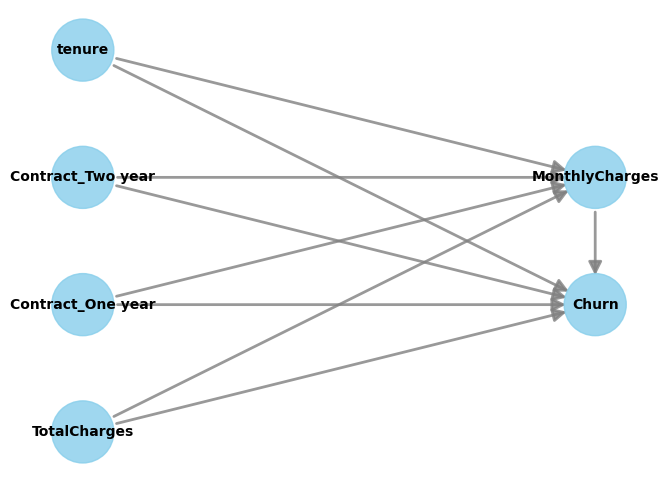

In [16]:
from dowhy import CausalModel

causal_model = CausalModel(
    data=df,
    treatment="MonthlyCharges",
    outcome="Churn",
    common_causes=[
        "tenure",
        "TotalCharges",
        "Contract_One year",
        "Contract_Two year"
    ]
)

causal_model.view_model()


### preprocess data

In [ ]:

import pandas as pd
import numpy as np

# df = pd.read_csv("Telco-Customer-Churn.csv")
df = pd.read_csv(p)

df = df[df["TotalCharges"] != " "]
df["TotalCharges"] = df["TotalCharges"].astype(float)

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

features = ["tenure","MonthlyCharges","TotalCharges","Contract","PaymentMethod"]
df = df[features + ["Churn"]]

df = pd.get_dummies(df, drop_first=True)
df.head()


,tenure,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,False,False,False,True,False
1,34,56.95,1889.50,0,True,False,False,False,True
2,2,53.85,108.15,1,False,False,False,False,True
3,45,42.30,1840.75,0,True,False,False,False,False
4,2,70.70,151.65,1,False,False,False,True,False


## Define treatment (High vs Low Monthly Charges)

In [ ]:

median_charge = df["MonthlyCharges"].median()
# print(median_charge)
df["HighCharge"] = (df["MonthlyCharges"] > median_charge).astype(int)


70.35


## 1. Naive Difference in Means

In [ ]:

treated = df[df["HighCharge"] == 1]["Churn"].mean()
control = df[df["HighCharge"] == 0]["Churn"].mean()
treated - control


np.float64(0.17252421829138342)

## 3. Propensity Score Matching (PSM)

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

confounders = df.drop(["Churn","MonthlyCharges","HighCharge"], axis=1)

ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(confounders, df["HighCharge"])

df["propensity_score"] = ps_model.predict_proba(confounders)[:,1]

treated = df[df["HighCharge"] == 1]
control = df[df["HighCharge"] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[["propensity_score"]])
distances, indices = nn.kneighbors(treated[["propensity_score"]])

matched_control = control.iloc[indices.flatten()]

treated["Churn"].mean() - matched_control["Churn"].mean()


np.float64(0.2926273840022772)